# Explain PyTorch MobileNetV2 using the `Partition` explainer

In this example we are explaining the output of MobileNetV2 for classifying images into 1000 ImageNet classes.

In [1]:
import json
import numpy as np
import torchvision
import torch
import torch.nn as nn
import shap
from PIL import Image

### Loading Model and Data

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
model = torchvision.models.mobilenet_v2(pretrained=True, progress=False)
model.to(device)
model.eval()
X, y = shap.datasets.imagenet50()

In [4]:
# Getting ImageNet 1000 class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]
print("Number of ImageNet classes:", len(class_names))
#print("Class names:", class_names)

Number of ImageNet classes: 1000


In [5]:
# Prepare data transformation pipeline

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def nhwc_to_nchw(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[1] == 3 else x.permute(0, 3, 1, 2)
    elif x.dim() == 3:
        x = x if x.shape[0] == 3 else x.permute(2, 0, 1)
    return x

def nchw_to_nhwc(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)
    elif x.dim() == 3:
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0)
    return x 
        

transform= [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Lambda(lambda x: x*(1/255)),
    torchvision.transforms.Normalize(mean=mean, std=std),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

inv_transform= [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Normalize(
        mean = (-1 * np.array(mean) / np.array(std)).tolist(),
        std = (1 / np.array(std)).tolist()
    ),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

transform = torchvision.transforms.Compose(transform)
inv_transform = torchvision.transforms.Compose(inv_transform)

In [6]:
def predict(img: np.ndarray) -> torch.Tensor:
    img = nhwc_to_nchw(torch.Tensor(img))
    img = img.to(device)
    output = model(img)
    return output

In [7]:
# Check that transformations work correctly
Xtr = transform(torch.Tensor(X))
out = predict(Xtr[1:3])
classes = torch.argmax(out, axis=1).cpu().numpy()
print(f'Classes: {classes}: {np.array(class_names)[classes]}')

Classes: [132 814]: ['American_egret' 'speedboat']


### Explain one image

In [8]:
topk = 4
batch_size = 50
n_evals = 10000

# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(128,128)", Xtr[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(predict, masker_blur, output_names=class_names)

# feed only one image
# here we explain two images using 100 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(Xtr[1:2], max_evals=n_evals, batch_size=batch_size,
                        outputs=shap.Explanation.argsort.flip[:topk])

Partition explainer: 2it [00:12,  6.44s/it]               


In [9]:
(shap_values.data.shape, shap_values.values.shape)

(torch.Size([1, 224, 224, 3]), (1, 224, 224, 3, 4))

In [10]:
shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0]
shap_values.values = [val for val in np.moveaxis(shap_values.values[0],-1, 0)]

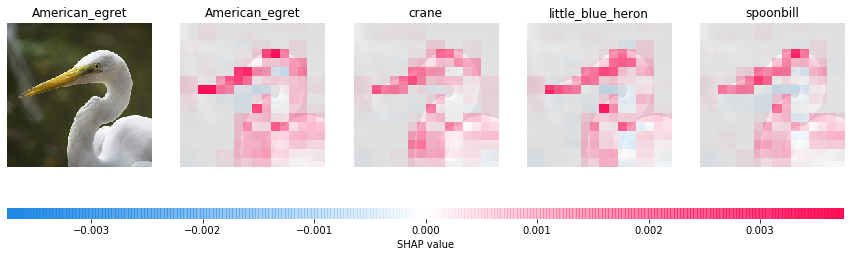

In [11]:
shap.image_plot(shap_values=shap_values.values, 
                pixel_values=shap_values.data, 
                labels=shap_values.output_names,
                true_labels=[class_names[132]])

### Explain multiple images

In [12]:
# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(128,128)", Xtr[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(predict, masker_blur, output_names=class_names)

# feed only one image
# here we explain two images using 100 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(Xtr[1:4], max_evals=n_evals, batch_size=batch_size,
                        outputs=shap.Explanation.argsort.flip[:topk])

Partition explainer:  33%|███▎      | 1/3 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 3/3 [00:21<00:00,  5.39s/it]

Partition explainer: 4it [00:32,  8.09s/it]                       


In [13]:
(shap_values.data.shape, shap_values.values.shape)

(torch.Size([3, 224, 224, 3]), (3, 224, 224, 3, 4))

In [14]:
shap_values.data = inv_transform(shap_values.data).cpu().numpy()
shap_values.values = [val for val in np.moveaxis(shap_values.values,-1, 0)]

In [15]:
(shap_values.data.shape, shap_values.values[0].shape)

((3, 224, 224, 3), (3, 224, 224, 3))

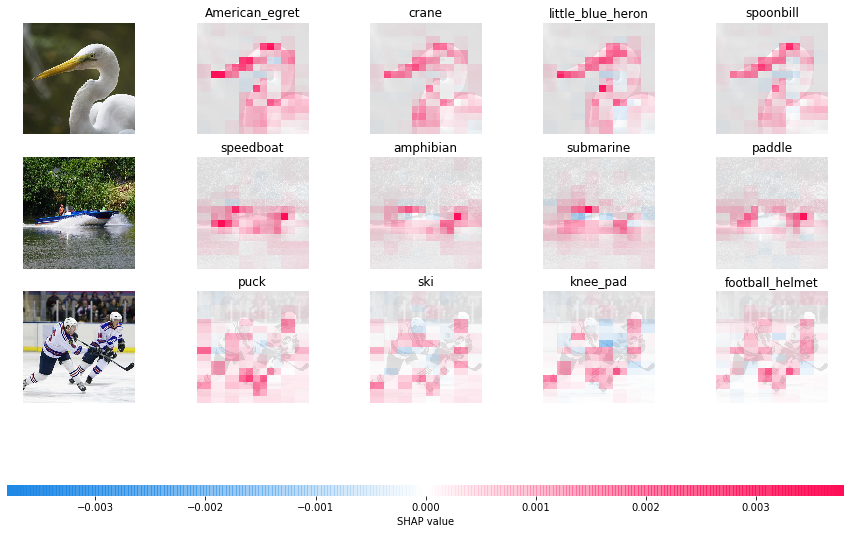

In [16]:
shap.image_plot(shap_values=shap_values.values,
                pixel_values=shap_values.data,
                labels=shap_values.output_names)